# Prepare the assets

We need to share with the customer a Darknet cfg that will be used during training/deployment.

Since we'll traing a YoloV2 to detect objects, in this case logos, we can start by downloading the Network Architecture.  
Then we need to customize it. To do that, you can use the following link as a reference:  
https://github.com/AlexeyAB/darknet/tree/47c7af1cea5bbdedf1184963355e6418cb8b1b4f#how-to-train-to-detect-your-custom-objects

## 1.0) Let's customize the .cfg of the yolov2 for the openlogo dataset

In [ ]:
## We'll train the model with a ml.p3.8xlarge. It has 4 Gpus, so let's adjust the batch size/divisions
num_classes = 335
iterations = 500 # 2000
max_batches = iterations * num_classes
steps_low = int(max_batches * .8)
steps_high = int(max_batches * .9)
filters = (num_classes + 5) * 5 # filters=(classes + 5)x5,

!curl -s -o input/assets/yolov2.cfg https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov2.cfg
    
!sed -i "s#batch=1#batch=64#" input/assets/yolov2.cfg
!sed -i "s#subdivisions=1#subdivisions=4#" input/assets/yolov2.cfg
!sed -i "s#max_batches = 500200#max_batches = $max_batches#" input/assets/yolov2.cfg
!sed -i "s#steps=400000,450000#steps=$steps_low,$steps_high#" input/assets/yolov2.cfg
!sed -i "s#classes=80#classes=$num_classes#" input/assets/yolov2.cfg
!sed -i "s#filters=425#filters=$filters#" input/assets/yolov2.cfg

!pygmentize input/assets/yolov2.cfg

## 2.0) Now, we can upload the assets and start the training

In [ ]:
import sagemaker
import boto3
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role

account_id = boto3.client("sts").get_caller_identity()["Account"]
region = boto3.session.Session().region_name

prefix='logo'
role = get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

In [ ]:
train_path="s3://%s/%s/input/training" % (bucket, prefix)
test_path="s3://%s/%s/input/testing" % (bucket, prefix)
assets_path = sagemaker_session.upload_data(path='input/assets', key_prefix='%s/assets' % prefix)
print("Training: %s\nTesting: %s\nAssets: %s" % (train_path, test_path, assets_path) )

In [ ]:
image_name='%s.dkr.ecr.%s.amazonaws.com/darknet:1.0' % (account_id, region)

estimator = Estimator(
    image_name=image_name,
    role=role,
    train_instance_count=1, 
    train_instance_type='ml.p3.8xlarge',
    sagemaker_session=sagemaker_session,
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    train_volume_size=100,
    train_max_run=100000,

    hyperparameters = {
        'num_classes': 335,
        'cfg': 'yolov2.cfg', # in assets
        'train_file': 'train.txt', # with the dataset
        'test_file': 'test.txt', # with the dataset
        'names_file': 'label.names', # in assets
        # 'weights': 'yolov2.weights', # [optional] in assets
        'sagemaker_s3_output': 's3://{}/{}/output'.format(bucket, prefix)
    },
    metric_definitions=[
        {'Name': 'iou:avg', 'Regex': 'Region Avg IOU: (\S+),'},
        {'Name': 'class:conf', 'Regex': 'Class: (\S+),'},
        {'Name': 'obj:conf', 'Regex': 'Obj: (\S+),'},
        {'Name': 'noobj:conf', 'Regex': 'No Obj: (\S+),'},
        {'Name': 'recall:avg', 'Regex': 'Avg Recall: (\S+),'},
        {'Name': 'learning:rate', 'Regex': ', (\S+) rate,'},
        {'Name': 'loss:avg', 'Regex': ', (\S+) avg,'}
    ]
)

In [ ]:
estimator.fit({'training': train_path, 'testing': test_path, 'assets': assets_path })

## 3.0) Deploy
We'll use here a P2 instance with just one GPU for the inference

In [ ]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.p2.xlarge')

## 4.0) Testing

In [7]:
%matplotlib inline

import cv2
import boto3
import matplotlib.pyplot as plt
from sagemaker.predictor import json_deserializer
predictor.accept = 'application/json'
predictor.content_type = 'image/jpeg'
predictor.serializer = None
predictor.deserializer = json_deserializer

Image: input/data/training/logos32plus_001759.jpg
Pred: [[58, 0.8333021998405457, [331.91693115234375, 532.3264770507812, 324.8536071777344, 357.4385986328125]]]
chimay
CPU times: user 43.4 ms, sys: 2.81 ms, total: 46.2 ms
Wall time: 1.26 s


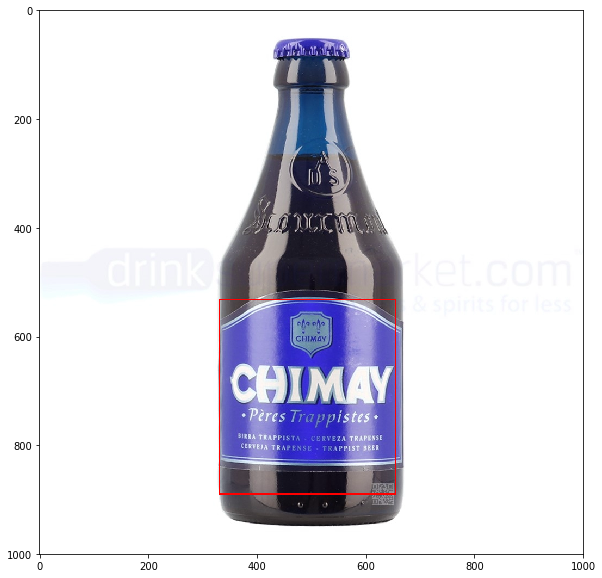

In [21]:
%%time
import glob
import random

labels = open('input/assets/label.names', 'r').read().split('\n')
images = glob.glob('input/data/training/*.jpg')
img_filename = images[random.randint(0, len(images)-1)]
with open(img_filename, 'rb') as i:
    payload = i.read()
    prediction = predictor.predict(payload)
    print("Image: %s" % img_filename)
    print("Pred: %s" % prediction)
    img = cv2.imread(img_filename)
    h,w,c = img.shape
    for bbox in prediction:
        class_id = bbox[0]
        class_conf = bbox[1]
        bbox_x, bbox_y, bbox_w, bbox_h = [int(x) for x in bbox[2]]
        print(labels[class_id])
        img = cv2.rectangle(img, (bbox_x, bbox_y), (bbox_x + bbox_w, bbox_y+bbox_h), (255,0,0), 2)

    plt.figure(figsize=(15,10))
    plt.imshow(img)

## 5.0) Delete the endpoint

In [22]:
import sagemaker
sagemaker.Session().delete_endpoint(predictor.endpoint)